In [1]:
import pandas as pd
import torch

import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import datetime as dt

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available()  else 'cpu')
device

device(type='mps')

# Import Dataset
Examine the data a little

In [3]:
#stock_data = pd.read_csv("./NVDA.csv", index_col="Date")
maindf = pd.read_csv("./NVDA.csv")
maindf = maindf.rename(columns={'Date': 'date','Open':'open','High':'high','Low':'low','Close':'close',
                                'Adj Close':'adj_close','Volume':'volume'})
maindf.shape, maindf.head()

((251, 7),
          date       open       high        low      close  adj_close  \
 0  2023-06-23  42.464001  42.808998  42.014999  42.209000  42.196365   
 1  2023-06-26  42.460999  42.764000  40.099998  40.632000  40.619839   
 2  2023-06-27  40.799000  41.939999  40.448002  41.875999  41.863468   
 3  2023-06-28  40.660000  41.845001  40.518002  41.117001  41.104694   
 4  2023-06-29  41.557999  41.599998  40.599998  40.821999  40.809780   
 
       volume  
 0  358140000  
 1  594322000  
 2  462175000  
 3  582639000  
 4  380514000  )

Check for any null or empty values in the data

In [4]:
print("Null values:", maindf.isnull().values.sum())
print("NA values:", maindf.isna().values.any())

Null values: 0
NA values: False


# Preprocess Data

In [5]:
# convert date field from string to Date format 
print(maindf['date'].head)
maindf['date'] = pd.to_datetime(maindf.date)
maindf['date'].head()

<bound method NDFrame.head of 0      2023-06-23
1      2023-06-26
2      2023-06-27
3      2023-06-28
4      2023-06-29
          ...    
246    2024-06-14
247    2024-06-17
248    2024-06-18
249    2024-06-20
250    2024-06-21
Name: date, Length: 251, dtype: object>


0   2023-06-23
1   2023-06-26
2   2023-06-27
3   2023-06-28
4   2023-06-29
Name: date, dtype: datetime64[ns]

# Data Exploration

In [8]:
print("Starting date: ",maindf.iloc[0][0])
print("Ending date: ", maindf.iloc[-1][0])
print("Duration: ", maindf.iloc[-1][0]-maindf.iloc[0][0])

Starting date:  2023-06-23 00:00:00
Ending date:  2024-06-21 00:00:00
Duration:  364 days 00:00:00


/var/folders/8q/h1fp60n52yqc7cccx0rtg7h40000gn/T/ipykernel_47500/881471916.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("Starting date: ",maindf.iloc[0][0])
/var/folders/8q/h1fp60n52yqc7cccx0rtg7h40000gn/T/ipykernel_47500/881471916.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("Ending date: ", maindf.iloc[-1][0])
/var/folders/8q/h1fp60n52yqc7cccx0rtg7h40000gn/T/ipykernel_47500/881471916.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by p

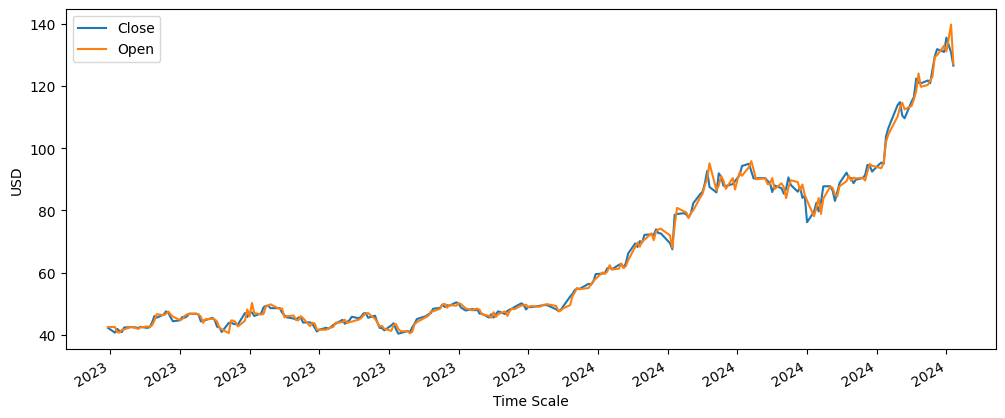

In [9]:
plt.figure(figsize=(12,5))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=30))
plt.gcf().autofmt_xdate()
plt.plot(maindf['date'], maindf['close'], label="Close")
plt.plot(maindf['date'], maindf['open'], label="Open")
plt.xlabel("Time Scale")
plt.ylabel("USD")
plt.legend()
plt.show()

# Preparing Closing Price - target data

In [10]:
closedf = maindf[['date','close']]
print("Shape of close dataframe:", closedf.shape)
closedf.head()

Shape of close dataframe: (251, 2)


,date,close
0,2023-06-23,42.209000
1,2023-06-26,40.632000
2,2023-06-27,41.875999
3,2023-06-28,41.117001
4,2023-06-29,40.821999


In [11]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score 
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
from sklearn.preprocessing import MinMaxScaler
import numpy as np

In [12]:
del closedf['date']
closedf.head()

,close
0,42.209000
1,40.632000
2,41.875999
3,41.117001
4,40.821999


In [13]:
scaler=MinMaxScaler(feature_range=(0,1))
closedf=scaler.fit_transform(np.array(closedf).reshape(-1,1))
print(closedf.shape)
closedf[:5], closedf.min(), closedf.max()

(251, 1)


(array([[0.0197682 ],
        [0.00321246],
        [0.01627227],
        [0.00830412],
        [0.00520712]]),
 0.0,
 1.0)

#Prepare train and test data

In [14]:
training_size=int(len(closedf)*0.60)
test_size=len(closedf)-training_size
train_data,test_data=closedf[0:training_size,:],closedf[training_size:len(closedf),:1]
print("train_data: ", train_data.shape)
print("test_data: ", test_data.shape)

train_data:  (150, 1)
test_data:  (101, 1)


In [15]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [31]:
time_step = 15
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_test: ", X_test.shape)
print("y_test", y_test.shape)

X_train:  (134, 15)
y_train:  (134,)
X_test:  (85, 15)
y_test (85,)


In [32]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

print("X_train: ", X_train.shape)
print("X_test: ", X_test.shape)

X_train:  (134, 15, 1)
X_test:  (85, 15, 1)


Convert the data to tensors

In [33]:
X_train = torch.from_numpy(X_train).type(torch.Tensor)
X_test = torch.from_numpy(X_test).type(torch.Tensor)
y_train = torch.from_numpy(y_train).type(torch.Tensor)
y_test = torch.from_numpy(y_test).type(torch.Tensor)

In [34]:
print('x_train.shape = ',X_train.shape)
print('y_train.shape = ',y_train.shape)
print('x_test.shape = ',X_test.shape)
print('y_test.shape = ',y_test.shape)

x_train.shape =  torch.Size([134, 15, 1])
y_train.shape =  torch.Size([134])
x_test.shape =  torch.Size([85, 15, 1])
y_test.shape =  torch.Size([85])


In [35]:
y_train.unsqueeze_(dim=1)
y_test.unsqueeze_(dim=1)
y_train.shape, y_test.shape

(torch.Size([134, 1]), torch.Size([85, 1]))

# Build the Model

In [36]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [37]:

input_dim = 1
hidden_dim = 32
num_layers = 2 
output_dim = 1

class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out

In [38]:
model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)

loss_fn = torch.nn.MSELoss()

optimiser = torch.optim.Adam(model.parameters(), lr=0.01)
print(model)
print(len(list(model.parameters())))
for i in range(len(list(model.parameters()))):
    print(list(model.parameters())[i].size())

LSTM(
  (lstm): LSTM(1, 32, num_layers=2, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)
10
torch.Size([128, 1])
torch.Size([128, 32])
torch.Size([128])
torch.Size([128])
torch.Size([128, 32])
torch.Size([128, 32])
torch.Size([128])
torch.Size([128])
torch.Size([1, 32])
torch.Size([1])


In [39]:
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

In [40]:
import time

num_epochs  = 10

hist = np.zeros(num_epochs)
start_time = time.time()
lstm = []

for t in range(num_epochs):
    y_train_pred = model(X_train)

    loss = criterion(y_train_pred, y_train)
    print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()

    optimiser.zero_grad()
    loss.backward()
    optimiser.step()
    
training_time = time.time()-start_time
print("Training time: {}".format(training_time))

Epoch  0 MSE:  0.0027794423513114452
Epoch  1 MSE:  0.013368586078286171
Epoch  2 MSE:  0.003160631749778986
Epoch  3 MSE:  0.002363386331126094
Epoch  4 MSE:  0.004074786324054003
Epoch  5 MSE:  0.0037838201969861984
Epoch  6 MSE:  0.0026895375922322273
Epoch  7 MSE:  0.002010471187531948
Epoch  8 MSE:  0.0019857159350067377
Epoch  9 MSE:  0.00232800655066967
Training time: 0.14625310897827148
